<a href="https://colab.research.google.com/github/cr21/ImageSegmentation/blob/main/Preprocessing_Indian_TrafficData.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
cd drive/MyDrive/Dataset/segmentation/

/content/drive/.shortcut-targets-by-id/1bynkOIXCurhJ9_Y5Q14KWX5yDyCRkKfN/segmentation


In [ ]:
#  you can skip this if you already have data extracted in Dataset 
# !apt install unzip
# !unzip  data.zip -d "/content/drive/MyDrive/Dataset/TrafficData"



In [8]:
os.chdir('/content/drive/MyDrive/Dataset/TrafficData/')

In [3]:
import math
from PIL import Image, ImageDraw
from PIL import ImagePath
import pandas as pd
import os
from os import path
from tqdm import tqdm
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt
import urllib
from os import listdir
from os.path import isfile, join
import pandas as pd
from tqdm import  tqdm
pd.options.display.max_colwidth =1000

<pre>

Inside the data we will be having two folders

|--- data
|-----| ---- images
|-----| ------|----- Scene 1
|-----| ------|--------| ----- Frame 1 (image 1)
|-----| ------|--------| ----- Frame 2 (image 2)
|-----| ------|--------| ----- ...
|-----| ------|----- Scene 2
|-----| ------|--------| ----- Frame 1 (image 1)
|-----| ------|--------| ----- Frame 2 (image 2)
|-----| ------|--------| ----- ...
|-----| ------|----- .....
|-----| ---- masks
|-----| ------|----- Scene 1
|-----| ------|--------| ----- json 1 (labeled objects in image 1)
|-----| ------|--------| ----- json 2 (labeled objects in image 1)
|-----| ------|--------| ----- ...
|-----| ------|----- Scene 2
|-----| ------|--------| ----- json 1 (labeled objects in image 1)
|-----| ------|--------| ----- json 2 (labeled objects in image 1)
|-----| ------|--------| ----- ...
|-----| ------|----- .....
</pre>

# Task 1: Preprocessing

## 1. Get all the file name and corresponding json files

In [4]:
def getPath(_dir):
  """
    Function to get All File path from directory.
    
    parameters: _dir (str) : directory name 

    returns : list 
  """
  paths = []
  subdirList = os.listdir(_dir)
  for subdir in sorted(subdirList):
    subdirPath = _dir + '/' + subdir
    imageList = [f for f in  sorted(listdir(subdirPath)) if isfile(join(subdirPath, f))]
    for image in imageList:
      imagePath = subdirPath + '/'+image
      paths.append(imagePath)
  return paths

In [5]:
def getFileNamesDataFrame(root_dir):
    """
      Function to create data frame with column "Image","Json"

      parameters: root_dir(str) : directory to look into

      returns Dataframe(pd.DataFrame) :  column "Image" having Image input data path, Column "Json" with path of JSON mask output detail.

    """
    images = getPath(root_dir+'/images')
    masks = getPath(root_dir+'/mask')
    # zip to create list of tuple
    dataset = list(zip(images, masks))
    data_df = pd.DataFrame(dataset, columns=["image","json"])
    return data_df

In [ ]:
root_dir = 'data'
data_df = getFileNamesDataFrame(root_dir)
data_df.head()

,image,json
0,data/images/201/frame0029_leftImg8bit.jpg,data/mask/201/frame0029_gtFine_polygons.json
1,data/images/201/frame0299_leftImg8bit.jpg,data/mask/201/frame0299_gtFine_polygons.json
2,data/images/201/frame0779_leftImg8bit.jpg,data/mask/201/frame0779_gtFine_polygons.json
3,data/images/201/frame1019_leftImg8bit.jpg,data/mask/201/frame1019_gtFine_polygons.json
4,data/images/201/frame1469_leftImg8bit.jpg,data/mask/201/frame1469_gtFine_polygons.json


In [ ]:
# datafram shape
data_df.shape

(4008, 2)

In [ ]:
# read data_df from csv if it is already processed
data_df = pd.read_csv("data_df.csv")
data_df.head()

## 2. Structure of sample Json file
<a href="https://imgur.com/IIMgxyo"><img src="https://i.imgur.com/IIMgxyo.png" title="source: imgur.com" /></a>

#### Let's see how many unique objects are there in the json file. 

In [77]:
def return_unique_labels(data_df):
    """
      Function to get all unique labels in entire dataset

      parameters : data_df(pd.DataFrame) : Dataframe having column "Image" and "Json"

      returns : unique_labels(set) : set of all unique labels in Image data

    """
    
    
    unique_labels = set()
    idx = 1
    for maskFile in tqdm(data_df["json"]):
      print(f"file {idx} processed")
      idx+=1
      jsonData = None
      # if open any json file using any editor you will get better sense of it
      with open(maskFile) as f:
        jsonData = json.load(f)

        if "objects" in jsonData:
          objectList = jsonData["objects"]
          # iterate over every object
          for _object in objectList:
            if "label" in _object:
              unique_labels.add(_object["label"])

    return unique_labels

In [ ]:
unique_labels = return_unique_labels(data_df)

In [ ]:
# data_df.to_csv('data_df.csv', index=False)


<a href="https://imgur.com/ghBvKA7"><img src="https://i.imgur.com/ghBvKA7.png" title="source: imgur.com" /></a>

In [24]:
#  create and updated ( grouped ) labels in 21 class and values were multiplied by 10 so that we can have different colors when 
# we plot the object
label_clr = {'road':10, 'parking':20, 'drivable fallback':20,'sidewalk':30,'non-drivable fallback':40,'rail track':40,\
                        'person':50, 'animal':50, 'rider':60, 'motorcycle':70, 'bicycle':70, 'autorickshaw':80,\
                        'car':80, 'truck':90, 'bus':90, 'vehicle fallback':90, 'trailer':90, 'caravan':90,\
                        'curb':100, 'wall':100, 'fence':110,'guard rail':110, 'billboard':120,'traffic sign':120,\
                        'traffic light':120, 'pole':130, 'polegroup':130, 'obs-str-bar-fallback':130,'building':140,\
                        'bridge':140,'tunnel':140, 'vegetation':150, 'sky':160, 'fallback background':160,'unlabeled':0,\
                        'out of roi':0, 'ego vehicle':170, 'ground':180,'rectification border':190,\
                   'train':200}

* here we have given a number for each of object types, if you see we are having 21 different set of objects
* Note that we have multiplies each object's number with 10, that is just to make different objects look differently in the segmentation map

## 3. Extracting the polygons from the json files

In [32]:
def getPolygonDetails(file):

    """
      Function will take a file name as argument , it will process all the objects in that file 
      to get width, height, object coordinated and labels from file.
    

      parameters : file(str) file name

      returns : tuple (width, height, labels, vertexlist) 
                [
                  width : widht of the image
                  height : height of the image
                  label : a list of labels for all the objects label[i] will have the corresponding vertices in vertexlist[i]
                  vertexlist :  it should be list of list of vertices in tuple formate 
                  ex: [[(x11,y11), (x12,y12), (x13,y13) .. (x1n,y1n)]
                        [(x21,y21), (x22,y12), (x23,y23) .. (x2n,y2n)]
                        .....
                        [(xm1,ym1), (xm2,ym2), (xm3,ym3) .. (xmn,ymn)]]
                    len(vertexlist) == number of objects in the image

                    label[i] and vertextlist[i] are corresponds to the same object, one represents the type of the object
                    # the other represents the location
                ]
    """
   
    w = None
    h = None
    label = []
    vertexlist = []
    with open(file) as f:
      jsonData = json.load(f)
      # print(jsonData)
      if "imgHeight" in jsonData:
        h = jsonData["imgHeight"]

      if "imgWidth" in jsonData:
        w = jsonData["imgWidth"]

      
      if "objects" in jsonData:
        objects = jsonData["objects"]
        for _object in  objects:
          if 'label' in _object:
            label.append(_object['label'])
          if "polygon" in _object:
            polygons = _object["polygon"]
            coordinates = []
            for _polygon in polygons:
              coordinates.append((_polygon [0], _polygon[1]))
            vertexlist.append(coordinates)
    
    return w, h, label, vertexlist

In [ ]:
w, h, labels, vertexlist = getPolygonDetails('data/mask/201/frame0029_gtFine_polygons.json')



## 4. Creating Image segmentations by drawing set of polygons

In [39]:
def compute_masks(data_df):

    """
      Function will create mask image for every input image in dataframe and output image path will be stored in new column in dataframe
      This function will iterate over every image in image column,
      then we will get labels and polygon information for every input image
      then we will fill the image with color according to labels and polygon location 
      finally updated image will be stored in output directory


      parameters : data_df(pd.DataFrame) -> ["Image", "Json"]

      return : data_df(pd.DataFrame) 
                  [
                    "Column 1" : "Image"
                    "Column 2" : "Json"
                    "Column 3" : "mask"
                  ]


    """
    # after you have computed the vertexlist plot that polygone in image like this
    
    # img = Image.new("RGB", (w, h))
    # img1 = ImageDraw.Draw(img)
    # img1.polygon(vertexlist[i], fill = label_clr[label[i]])
    
    # after drawing all the polygons that we collected from json file, 
    # you need to store that image in the folder like this "data/output/scene/framenumber_gtFine_polygons.png"
    
    # after saving the image into disk, store the path in a list
    # after storing all the paths, add a column to the data_df['mask'] ex: data_df['mask']= mask_paths
    maskPaths = []
    for maskJson in tqdm(data_df["json"]): 
      w, h, labels, vertexlist = get_poly(maskJson)
      # create image
      img = Image.new("RGB", (w,h))
      img1 = ImageDraw.Draw(img)
      for index,vertexset in  enumerate (vertexlist):
        # draw polygon with label color
        #  if vertex set is valid tuple
        if not len(vertexset) < 2:
          img1.polygon(vertexset, fill = label_clr[labels[index]])
      img=np.array(img)
      im = Image.fromarray(img[:,:,0])
      #filling of the values happens at the channel 1, so we are considering only the first channel here
      # plt.imshow(img[:,:,0])
      dir_to_store = 'data/output/'  + maskJson[10:13]
      if  not  os.path.isdir(dir_to_store):
        os.makedirs(dir_to_store)
      maskPath = 'data/output/' + maskJson[10:-5] + '.png'

      # maskPath = maskJson.replace("mask","output")
      # maskPath = maskPath.replace(".json",".png")
      
      maskPaths.append(maskPath)
      im.save(maskPath)
      
    data_df['mask'] = np.array(maskPaths)
    return data_df

In [ ]:
data_df = compute_masks(data_df)

In [41]:
data_df.head()

,image,json,mask
0,data/images/201/frame0029_leftImg8bit.jpg,data/mask/201/frame0029_gtFine_polygons.json,data/output/201/frame0029_gtFine_polygons.png
1,data/images/201/frame0299_leftImg8bit.jpg,data/mask/201/frame0299_gtFine_polygons.json,data/output/201/frame0299_gtFine_polygons.png
2,data/images/201/frame0779_leftImg8bit.jpg,data/mask/201/frame0779_gtFine_polygons.json,data/output/201/frame0779_gtFine_polygons.png
3,data/images/201/frame1019_leftImg8bit.jpg,data/mask/201/frame1019_gtFine_polygons.json,data/output/201/frame1019_gtFine_polygons.png
4,data/images/201/frame1469_leftImg8bit.jpg,data/mask/201/frame1469_gtFine_polygons.json,data/output/201/frame1469_gtFine_polygons.png


False
[  0  10  20  40  50  60  70  80  90 100 120 130 140 150 160]
[  0  10  20  40  50  60  70  80  90 100 120 130 140 150 160]


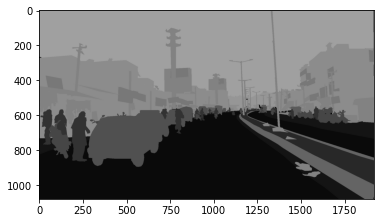

In [76]:
def grader_3():
    url = "https://i.imgur.com/4XSUlHk.png"
    url_response = urllib.request.urlopen(url)
    img_array = np.array(bytearray(url_response.read()), dtype=np.uint8)
    img = cv2.imdecode(img_array, -1)
    my_img = cv2.imread('data/output/201/frame0029_gtFine_polygons.png')    
    plt.imshow(my_img)
    print((my_img[:,:,0]==img).all())
    print(np.unique(img))
    print(np.unique(my_img[:,:,0]))
    data_df.to_csv('preprocessed_data.csv', index=False)
grader_3()

In [ ]:
"""
    Function to Display Images from Dataset.
    
    parameters: images_path(string) - Paths of Images to be displayed
                rows(int) - No. of Rows in Output
                cols(int) - No. of Columns in Output
    """